In [1]:
import os
import math
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
# fix random seed for reproducibility
np.random.seed(17896)

In [2]:
# Part 1: User Input

T = 298                    # temperature (K)
L = 2.4                    # cubic box side length(nm)
N = 25                     # number of atoms
dt = 0.0001                # time step (ps)
nSteps = 50000             # number of steps
rc = 1.2                   # Lennard-Jones cutoff (nm)
printModulus = 100         # prints to screen
writeModulus = 100         # writes to file
sigma = 0.34               # LJ size parameter (nm)
epsilon = 1.65             # LJ energy parameter (zJ)
m = 39.948                 # molecular weight for Ar (g/mol)
kB = 0.0138064852          # Boltzmann's constant (zJ/K)

In [3]:
# Part 2: Periodic boundaries and minimum image distance

def wrap(r, L):
    """Wrap the coordinates in r (an array-like with 3 elements) into the interval [0, L)."""
    return np.mod(r, L)


def dist(r1, r2, L):
    """
    Compute the minimum-image distance between two points r1 and r2
    in a cubic periodic box of side L.
    """
    dr = r2 - r1
    # Shift dr into the interval (-L/2, L/2]
    dr -= L * np.floor(dr / L + 0.5)
    return np.linalg.norm(dr)
    

In [4]:
# Part 3: Pairwise Energy

def E_ij(r, sigma, epsilon, rc):
    """
    Compute the Lennard-Jones potential energy between two particles
    separated by a distance s.
    """
    if r > rc:
        return 0  # Potential is set to zero beyond the cutoff
    
    sr6 = (sigma / r) ** 6
    sr_c6 = (sigma / rc) ** 6
    V_LJ_r_c = 4 * epsilon * (sr_c6**2 - sr_c6)  # Shift term

    return 4 * epsilon * (sr6**2 - sr6) - V_LJ_r_c  # Truncated and shifted LJ potential



In [5]:
# Part 4: Pairwise Force

import numpy as np

def f_ij(r, sigma, epsilon, rc):
    """
    Compute the Lennard-Jones force vector exerted on particle i by particle j 
    under the truncated and shifted Lennard-Jones potential.
    """
    s = np.linalg.norm(r)  # Compute scalar distance |r|
    
    if s > rc:
        return np.zeros_like(r)  # Force is zero beyond cutoff

    sr6 = (sigma / s) ** 6
    sr_c6 = (sigma / rc) ** 6

    # Compute the Lennard-Jones force magnitude
    force_magnitude = -48 * epsilon * (sr6**2 - 0.5 * sr6) / s**2

    return force_magnitude * r  # Return force vector


In [6]:
# Part 5: Tail Corrections

def E_tail(N, L, sigma, epsilon, rc):
    rho = N/(L**3)
    sigrc = (sigma/rc)**3
    prefac = 8/3*np.pi*rho*epsilon*sigma**3
    return prefac*(1/3*(sigrc**3) - sigrc)
    
def P_tail(N, L, sigma, epsilon, rc):
    rho = N/(L**3)
    sigrc = (sigma/rc)**3
    prefac = 16/3*np.pi*rho**2*epsilon*sigma**3
    return prefac * (2/3*(sigrc)**3 - sigrc)


### Derivation of the Tail Corrections

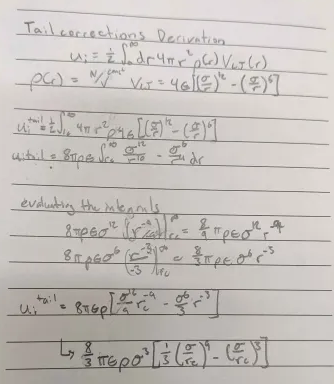

In [7]:
# Part 6: Coordinate Initialization

def init_rand(N, L, sigma):
    """
    Initialize N particle positions randomly in a box of side L,
    ensuring that no two particles are closer than sigma.
    """
    xyz = np.empty((N, 3))
    for i in range(N):
        # print(f'  Inserting particle {i+1}')
        while True:
            candidate = np.random.uniform(0, L, 3)
            # Check candidate against all already placed particles.
            if all(dist(candidate, xyz[j], L) >= sigma for j in range(i)):
                xyz[i] = candidate
                break
    # print('Done!')

    # Verify that no collisions remain.
    for i in range(N):
        for j in range(i):
            if dist(xyz[i], xyz[j], L) < sigma:
                raise Exception(f'Collision between particles {i+1} and {j+1}')
    return np.array(xyz)


def init_xtal(N, L):
    """
    Initialize N particle positions on a simple cubic lattice (crystal)
    inside a box of side L.
    """
    K = int(np.ceil(N ** (1/3)))  # Number of particles per side of the cube.
    # Create a full grid then take the first N positions.
    grid = [[i/K * L, j/K * L, k/K * L]
            for i in range(K) for j in range(K) for k in range(K)]
    return np.array(grid[:N])

In [8]:
# Part 7: Velocity Initialization

def vMaxBoltz(T,N,m):

    sigma = np.sqrt(kB * T / m)
    v_xyz = np.random.normal(0, sigma, (N, 3))
    v_cm = np.mean(v_xyz, axis=0)  # Compute center of mass velocity
    v_xyz -= v_cm  # Adjust velocities

    return np.array(v_xyz)
    

In [9]:
# Part 8: Energy

# Potential Energy Of the System
def E_pot(xyz, L, sigma, epsilon):
    """Compute the total energy of the system by summing over all unique pairs."""
    E = sum(E_ij(dist(r1, r2, L), sigma, epsilon, rc) for r1, r2 in combinations(xyz, 2))
    # Return the sum of energy + the tail energy
    return E +  E_tail(N, L, sigma, epsilon, rc)

def E_kin(v_xyz, m): 
    return (.5*m*np.sum(v_xyz**2))

In [10]:
# Part 9: Pressure
def r_ij(r1, r2, L):
    disp = r2 - r1
    return disp - L * np.round(disp / L)
    
def pressure(N, L, T, xyz, sigma, epsilon, rc):
    V = L**3
    P_ideal = (N * kB * T) / V
    virial_sum = 0.0

    # Loop over all unique pairs (i, j)
    for i in range(N):
        for j in range(i + 1, N):
            # Compute the minimum-image displacement vector
            rij = r_ij(xyz[i], xyz[j], L)
            fij = f_ij(rij, sigma, epsilon, rc)
            virial_sum += np.dot(fij, rij)
            
    
    # Compute the pressure from the ideal gas and virial and tail contributions 
    return P_ideal - virial_sum / (3 * V) + P_tail(N, L, sigma, epsilon, rc)

In [11]:
# Part 10: Temperature

#make use of kinetic energy
def temperature(v_xyz, m, N):
    """
    Compute the instantaneous temperature of the system using the equipartition principle.
    """

    # Compute kinetic energy
    E_kin_value = E_kin(v_xyz, m)

    # Compute temperature using equipartition theorem
    T = (2 * E_kin_value) / (3 * N * kB)

    return T


In [12]:
# Part 11: Coordinate Write

# writing coordinates to file
def xyzWrite(xyz, outfile, writeStyle):
    """Write particle coordinates (converted to Angstroms) to a file."""
    N = xyz.shape[0]
    with open(f'./{outfile}', writeStyle) as xyzfile:
        xyzfile.write(f"{N}\n\n")
        for x, y, z in xyz:
            xyzfile.write(f"Ar {x*10:8.5e} {y*10:8.5e} {z*10:8.5e}\n")



In [13]:
# Part 12: Forces

def forces(N, xyz, L, sigma, epsilon, rc):
    f_xyz = np.zeros((N, 3))  # Initialize force array
    
    # Loop over all unique pairs (i, j)
    for i in range(N):
        for j in range(i + 1, N):
            # Compute the minimum-image displacement vector
            rij = r_ij(xyz[i], xyz[j], L)
            fij = f_ij(rij, sigma, epsilon, rc)

            # Newton's Third Law: f_ij = -f_ji
            f_xyz[i] += fij
            f_xyz[j] -= fij

    return np.array(f_xyz)
        

In [14]:
# Part 13: Velocity Verlet

def velocityVerlet(N, xyz, v_xyz, L, sigma, epsilon, rc, m, dt):
    """ Perform a single iteration of the Verlet algorithm to update positions. """
    # Initial forces
    f_xyz = forces(N, xyz, L, sigma, epsilon, rc)

    # Velocity half step
    v_half = v_xyz + dt/(2*m) * f_xyz

    # Positions
    xyz = wrap((xyz + v_half * dt), L)

    # Forces update
    f_new = forces(N, xyz, L, sigma, epsilon, rc)

    # Velocity update
    v_xyz = v_half + dt/(2*m) * f_new

    return xyz, v_xyz, f_new

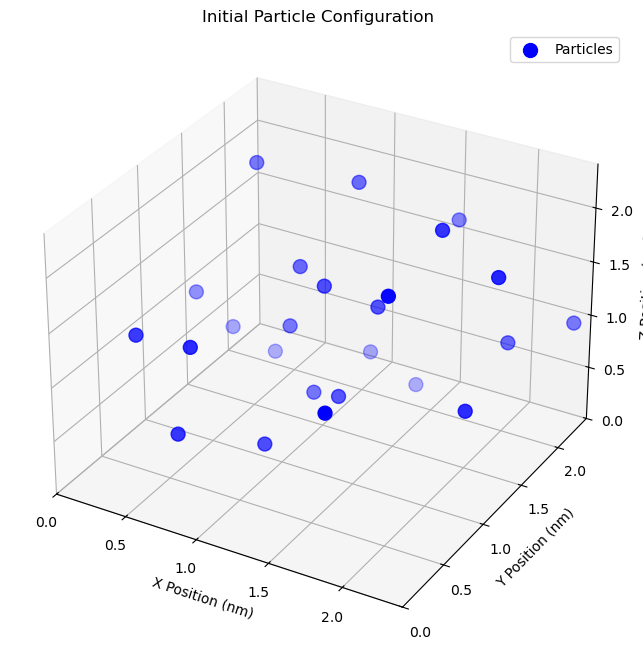

In [19]:
# Initialization of velocities and Positions
xyz = init_rand(N, L, sigma)
v_xyz = vMaxBoltz(T,N,m)

#Writing the files of position and velocity
xyzWrite(xyz,'init.xyz', 'w')
xyzWrite(xyz,'traj.xyz', 'w')
xyzWrite(v_xyz,'init_vel.xyz', 'w')
xyzWrite(v_xyz,'traj_vel.xyz', 'w')

# 3d plot of positions before simulation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of particles
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=100, c='blue', label="Particles")

# Set plot limits to box size
ax.set_xlim([0, L])
ax.set_ylim([0, L])
ax.set_zlim([0, L])

# Labels and title
ax.set_xlabel("X Position (nm)")
ax.set_ylabel("Y Position (nm)")
ax.set_zlabel("Z Position (nm)")
ax.set_title("Initial Particle Configuration")

# Show grid and legend
ax.legend()
ax.grid(True)

plt.show()

In [20]:
# Part 14: Molecular dynamics main loop
E_kin_traj = []
E_pot_traj = []
E_tot_traj = []
T_traj = []
P_traj = []
E_tail_traj = []
P_tail_traj = []

for step in range(nSteps):
    
    xyz, v_xyz, f_new = velocityVerlet(N, xyz, v_xyz, L, sigma, epsilon, rc, m, dt)

    if step % printModulus == 0:
        E_kins = E_kin(v_xyz, m)
        E_pots = E_pot(xyz, L, sigma, epsilon)
        E_tot = E_kins + E_pots
        T = temperature(v_xyz, m, N)
        P = pressure(N, L, T, xyz, sigma, epsilon, rc)
        P_tails = P_tail(N, L, sigma, epsilon, rc)
        E_tails = E_tail(N, L, sigma, epsilon, rc)
        E_kin_traj.append(E_kins)
        E_pot_traj.append(E_pots)
        E_tot_traj.append(E_tot)
        T_traj.append(T)
        P_traj.append(P)
        E_tail_traj.append(P_tails)
        P_tail_traj.append(E_tails)
        print(f' Step = {step}')
        print(f' E_kin = {E_kins:.5e} zJ')
        print(f' E_pot = {E_pots:.5e} zJ')
        print(f' E_tot = {E_tot:.5e} zJ')
        print(f' T = {T} K')
        print(f' P = {P:.5e} zJ/nm³')
        print(f' P_tail = {P_tails:.5e} zJ/nm³')
        print(f' E_tail = {E_tails:.5e} zJ')

    if step % writeModulus == 0:
        xyzWrite(xyz,'traj.xyz', 'a')
        xyzWrite(v_xyz,'traj_vel.xyz', 'a')
        

 Step = 0
 E_kin = 1.57662e+02 zJ
 E_pot = -1.60039e+01 zJ
 E_tot = 1.41658e+02 zJ
 T = 304.5171623629464 K
 P = 6.14659e+00 zJ/nm³
 P_tail = -8.08025e-02 zJ/nm³
 E_tail = -2.23441e-02 zJ
 Step = 100
 E_kin = 1.57583e+02 zJ
 E_pot = -1.59257e+01 zJ
 E_tot = 1.41658e+02 zJ
 T = 304.36612544717724 K
 P = 6.11844e+00 zJ/nm³
 P_tail = -8.08025e-02 zJ/nm³
 E_tail = -2.23441e-02 zJ
 Step = 200
 E_kin = 1.57466e+02 zJ
 E_pot = -1.58085e+01 zJ
 E_tot = 1.41658e+02 zJ
 T = 304.13966378830634 K
 P = 6.10465e+00 zJ/nm³
 P_tail = -8.08025e-02 zJ/nm³
 E_tail = -2.23441e-02 zJ
 Step = 300
 E_kin = 1.57312e+02 zJ
 E_pot = -1.56537e+01 zJ
 E_tot = 1.41658e+02 zJ
 T = 303.84084308384195 K
 P = 6.10646e+00 zJ/nm³
 P_tail = -8.08025e-02 zJ/nm³
 E_tail = -2.23441e-02 zJ
 Step = 400
 E_kin = 1.57122e+02 zJ
 E_pot = -1.54643e+01 zJ
 E_tot = 1.41658e+02 zJ
 T = 303.47499860264276 K
 P = 6.12409e+00 zJ/nm³
 P_tail = -8.08025e-02 zJ/nm³
 E_tail = -2.23441e-02 zJ
 Step = 500
 E_kin = 1.56902e+02 zJ
 E_pot = -1.

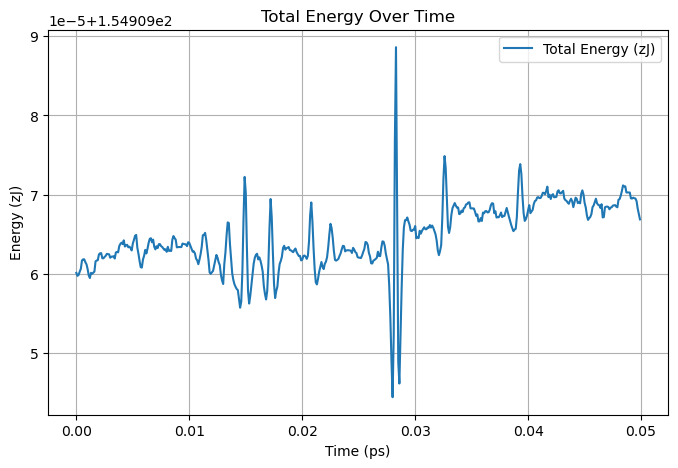

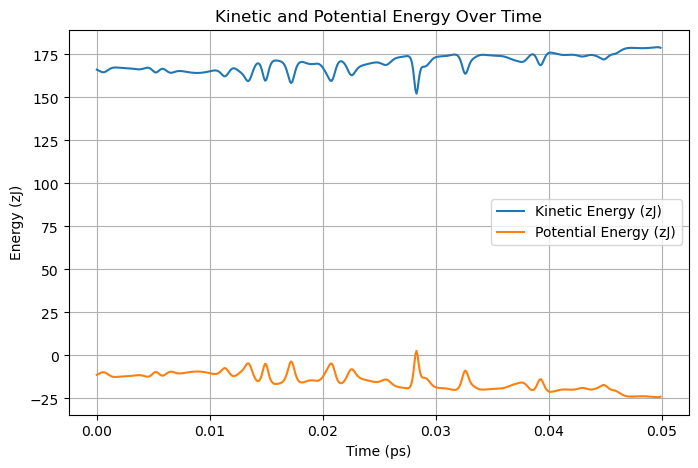

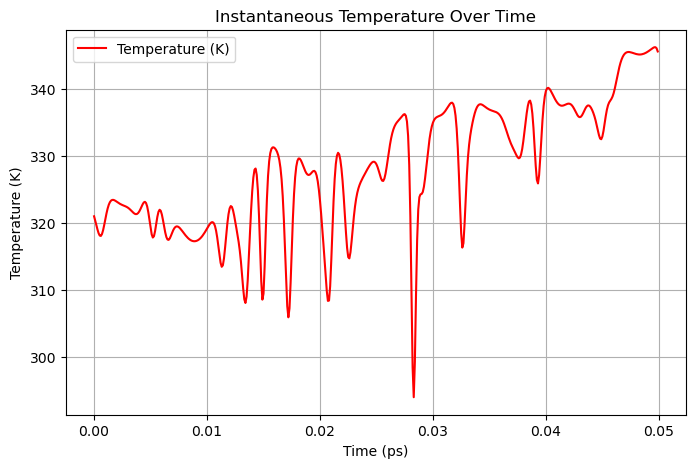

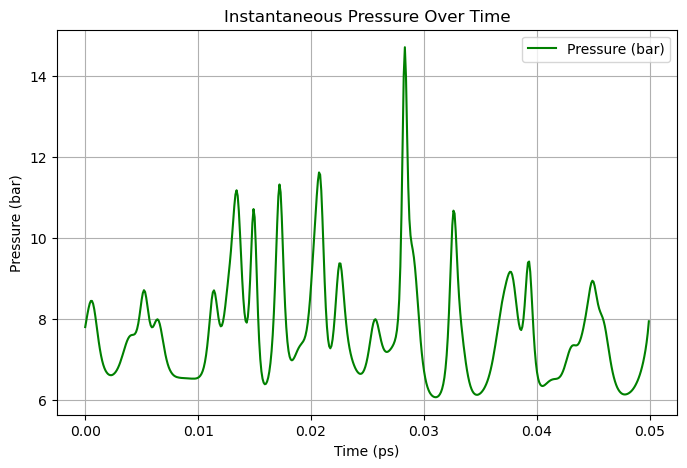

In [17]:
# Part 15: Production Run


# Extract time series data
time = np.arange(0, nSteps/printModulus, 1) * dt  # Convert steps to time in ps

# Plot total energy conservation
plt.figure(figsize=(8, 5))
plt.plot(time, E_tot_traj, label="Total Energy (zJ)")
plt.xlabel("Time (ps)")
plt.ylabel("Energy (zJ)")
plt.title("Total Energy Over Time")
plt.legend()
plt.grid()
plt.show()

# Plot kinetic and potential energy separately
plt.figure(figsize=(8, 5))
plt.plot(time, E_kin_traj, label="Kinetic Energy (zJ)")
plt.plot(time, E_pot_traj, label="Potential Energy (zJ)")
plt.xlabel("Time (ps)")
plt.ylabel("Energy (zJ)")
plt.title("Kinetic and Potential Energy Over Time")
plt.legend()
plt.grid()
plt.show()

# Plot temperature over time
plt.figure(figsize=(8, 5))
plt.plot(time, T_traj, label="Temperature (K)", color="red")
plt.xlabel("Time (ps)")
plt.ylabel("Temperature (K)")
plt.title("Instantaneous Temperature Over Time")
plt.legend()
plt.grid()
plt.show()

# Plot pressure over time
plt.figure(figsize=(8, 5))
plt.plot(time, P_traj, label="Pressure (bar)", color="green")
plt.xlabel("Time (ps)")
plt.ylabel("Pressure (bar)")
plt.title("Instantaneous Pressure Over Time")
plt.legend()
plt.grid()
plt.show()


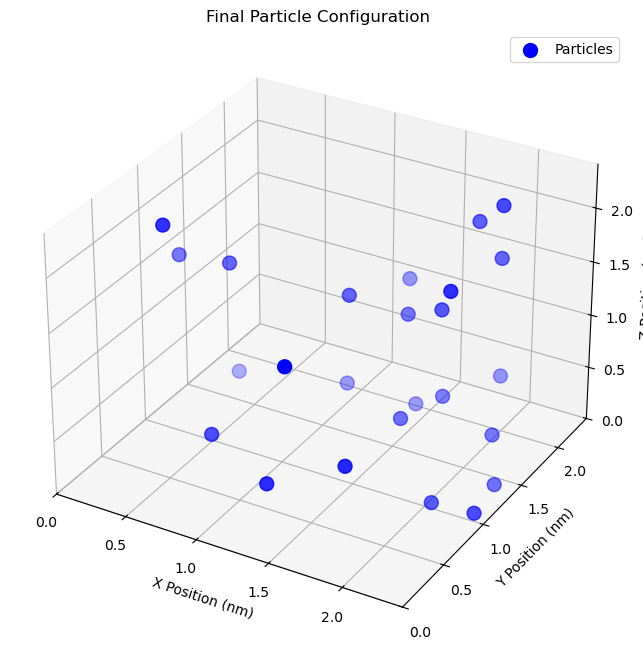

In [18]:
# 3d plot of positions after simulation

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of particles
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=100, c='blue', label="Particles")

# Set plot limits to box size
ax.set_xlim([0, L])
ax.set_ylim([0, L])
ax.set_zlim([0, L])

# Labels and title
ax.set_xlabel("X Position (nm)")
ax.set_ylabel("Y Position (nm)")
ax.set_zlabel("Z Position (nm)")
ax.set_title("Final Particle Configuration")

# Show grid and legend
ax.legend()
ax.grid(True)

plt.show()